# House Prices - Advanced Regression Techniques

## James Morgan (jhmmorgan)
*2021-10-18*

### 1. Set Up
##### 1.1 Import Libraries

In [93]:
import pandas as pd
import numpy as np
import math

# Use this cell to begin, and add as many cells as you need to complete your analysis!
# Libaries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.special import boxcox, inv_boxcox
#from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE


##### 1.2 Default classes
Used for better printing outputs.

In [94]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

##### 1.3 Load Data
Lets read in the data...

However, before we do, the data description shows NA as being a valid value for many of the categories
Normally meaning none, i.e. Alley == NA means no alley access, not missing data. We'll therefore override the default NA's to ignore "NA" from the NA list.


In [95]:
# Get the default NA values from Pandas and remove "NA". Use this as the default list of NA's
_na_values = ['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A N/A', '#N/A', 'N/A', 'n/a', '<NA>', '#NA', 'NULL', 'null', 'NaN', '-NaN', 'nan', '-nan', '']

# Now we can read the files
src_path      = "house-prices-advanced-regression-techniques/"
test_df       = pd.read_csv(src_path + "test.csv", keep_default_na = True)#, na_values = _na_values)
train_df      = pd.read_csv(src_path + "train.csv", keep_default_na = True)#, na_values = _na_values)
sample_sub_df = pd.read_csv(src_path + "sample_submission.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [96]:
# Using Ids as Indexes
for df in [train_df, test_df]:
    df.set_index("Id", inplace=True)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. EDA (Exploratory Data Analysis)
###### 2.1 Data Check

In [97]:
# Data Type Check
df = pd.DataFrame({"Column": train_df.columns, "Dtype": train_df.dtypes.astype("str").tolist(), 
                   "Sample1": train_df.loc[1].tolist(),
                   "Sample2": train_df.loc[50].tolist(), 
                   "Sample3": train_df.loc[500].tolist()})
print(color.BOLD + color.UNDERLINE + "Data Types for all features in the training data frame" + color.END)
print(df.to_string())

Data Types for all features in the training data frame
           Column    Dtype  Sample1  Sample2  Sample3
0      MSSubClass    int64       60       20       20
1        MSZoning   object       RL       RL       RL
2     LotFrontage  float64     65.0     66.0     70.0
3         LotArea    int64     8450     7742     7535
4          Street   object     Pave     Pave     Pave
5           Alley   object      NaN      NaN      NaN
6        LotShape   object      Reg      Reg      IR1
7     LandContour   object      Lvl      Lvl      Lvl
8       Utilities   object   AllPub   AllPub   AllPub
9       LotConfig   object   Inside   Inside   Inside
10      LandSlope   object      Gtl      Gtl      Gtl
11   Neighborhood   object  CollgCr   Sawyer    NAmes
12     Condition1   object     Norm     Norm     Norm
13     Condition2   object     Norm     Norm     Norm
14       BldgType   object     1Fam     1Fam     1Fam
15     HouseStyle   object   2Story   1Story   1Story
16    OverallQual    int64 

###### Observations:
* **MSSubClass**, **MoSold**, **YrSold** are categorical, but stored as numbers
* **OverallQal**, **OverallCond** are also categorical, however with a scale of 1 to 10 so are ok to remain numbers
* **CentralAir** is a Y/N and so should be a boolean
* Various features have missing values, however **NA** was one of their options.

We need to change these in both the training and test datasets.

We'll first replace any null value in the specified columns to the string "NA":

In [98]:
# Array of features with NA as a valid option
features_with_NA = ["Alley",
                    "BsmtQual",
                    "BsmtCond",
                    "BsmtExposure",
                    "BsmtFinType1",
                    "BsmtFinType2",
                    "FireplaceQu",
                    "GarageType",
                    "GarageFinish",
                    "GarageQual",
                    "GarageCond",
                    "PoolQC",
                    "Fence",
                    "MiscFeature"]

for feature in features_with_NA:
    for df in [train_df, test_df]:
        df.replace({feature: {np.NAN : "NA"}}, inplace=True)

train_df[features_with_NA].head()

,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
Id,,,,,,,,,,,,,,
1,NA,Gd,TA,No,GLQ,Unf,NA,Attchd,RFn,TA,TA,NA,NA,NA
2,NA,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA
3,NA,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA
4,NA,TA,Gd,No,ALQ,Unf,Gd,Detchd,Unf,TA,TA,NA,NA,NA
5,NA,Gd,TA,Av,GLQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA


We'll now replace various integers to appropriate categories:

In [99]:
for df in [train_df, test_df]:
    df.replace({"MSSubClass": {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45", 50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75",
                               80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120", 150: "SC150", 160: "SC160", 180: "SC180", 190: "SC190"}, 
                "MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                           7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"},
                "CentralAir": {"Y": True, "N": False}},
                inplace=True)
    df["YrSold"] = pd.Categorical(df.YrSold)

train_df[["MSSubClass", "YrSold", "MoSold", "CentralAir"]].head()

,MSSubClass,YrSold,MoSold,CentralAir
Id,,,,
1,SC60,2008,Feb,True
2,SC20,2007,May,True
3,SC60,2008,Sep,True
4,SC70,2006,Feb,True
5,SC60,2008,Dec,True


##### 2.2 Missing Values
We now need to review and clean any missing value.

In [100]:
_train_df      = train_df.drop(columns = "SalePrice")
combined_df = pd.concat([_train_df, test_df])

print(color.BOLD + "Which features contain null values?" + color.END)
print(combined_df.isnull().sum()[combined_df.isnull().sum()>0])

Which features contain null values?
MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageYrBlt     159
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64


We can fill most of these in by looking at the data description by using defaults such as "Other" or "None.
The numeric values can have 0, such as those with square feet metrics.

**GarageYrBlt** contains a year, or is blank if there is no garage.  We can change this to a categorical feature.

In [101]:
# Filling the Missing Values
MSZoning_series    = combined_df.groupby("Neighborhood").MSZoning.agg(lambda x:x.value_counts().index[0])
LotFrontage_series = combined_df.groupby("Neighborhood").LotFrontage.median()

combined_df_filled = combined_df.fillna({"Utilities": "AllPub",
                                         "Exterior1st":"Other",
                                         "Exterior2nd":"Other",
                                         "MasVnrType":"None",
                                         "MasVnrArea":0,
                                         "BsmtFinSF1":0,
                                         "BsmtFinSF2":0,
                                         "BsmtUnfSF":0,
                                         "TotalBsmtSF":0,
                                         "Electrical":"SBrkr",
                                         "BsmtFullBath":0,
                                         "BsmtHalfBath":0,
                                         "KitchenQual":"TA",
                                         "Functional":"Typ",
                                         "GarageYrBlt":"None",
                                         "GarageCars":0,
                                         "GarageArea":0,
                                         "SaleType":"Oth",
                                         "MSZoning": combined_df["Neighborhood"].apply(lambda x: MSZoning_series[x]),
                                         "LotFrontage": combined_df["Neighborhood"].apply(lambda x: LotFrontage_series[x])})


combined_df_filled["GarageYrBlt"] = pd.Categorical(combined_df_filled.GarageYrBlt)

print(color.BOLD + "Number of null values?" + color.END)
print(combined_df_filled.isnull().sum().sum())

Number of null values?
0


Fantastic! There are no null values.

We can now split the combined dataframe back into the train and test dataframes.

In [102]:
train_df_filled = combined_df_filled.iloc[:len(train_df)]
train_df_filled = pd.concat([train_df_filled, train_df['SalePrice']], axis=1)
test_df_filled = combined_df_filled.iloc[len(train_df):]

##### 2.3 Visualisation of the data
###### 2.3.1. SalePrice
We now need to visualise the data.

**How evenly distributed is the sale price (target) in our training data?**

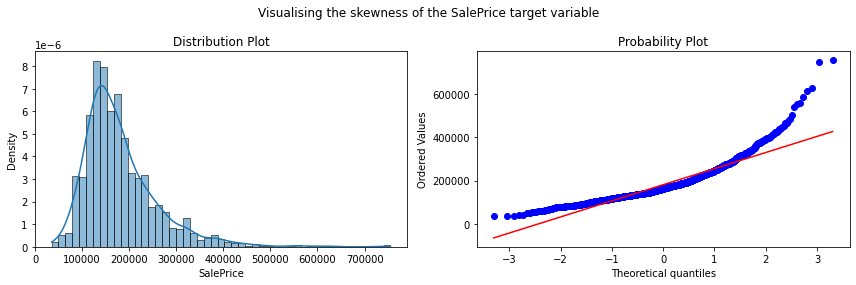

<Figure size 432x288 with 0 Axes>

In [103]:
# Figure
plt.figure(figsize=(12, 4))
plt.suptitle("Visualising the skewness of the SalePrice target variable")

# Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(train_df_filled["SalePrice"], stat = "density", kde = True)
plt.title('Distribution Plot')

# Probability Plot
plt.subplot(1, 2, 2)
stats.probplot(train_df_filled['SalePrice'], plot=plt)

plt.tight_layout()
plt.show()
plt.clf()

In [104]:
skew_SalePrice   = train_df_filled.SalePrice.skew()
log1p_SalePrice  = np.log1p(train_df_filled.SalePrice).skew()
sqrt_SalePrice   = np.sqrt(train_df_filled.SalePrice).skew()
boxcox_SalePrice = pd.Series(boxcox(train_df_filled.SalePrice, 0)).skew()

skewed_results = pd.DataFrame({"Untransformed":[skew_SalePrice], 
                               "log1p":[log1p_SalePrice],
                               "Square Root": [sqrt_SalePrice],
                               "boxcox":[boxcox_SalePrice]})

print(color.BOLD + "Skewness of untransformed SalePrice target variable, vs various transformation techniques" + color.END)
print(skewed_results)

Skewness of untransformed SalePrice target variable, vs various transformation techniques
   Untransformed     log1p  Square Root    boxcox
0       1.882876  0.121347     0.943153  0.121335


The SalePrice appears skewed. A log1p transformation smooths this better than the square root.  The boxcox is only marginally better and personally less preferred.

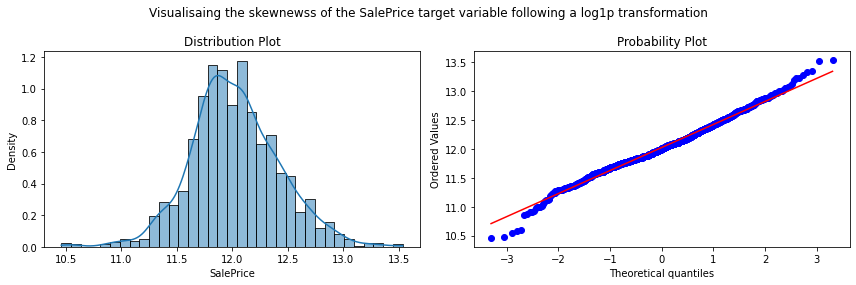

<Figure size 432x288 with 0 Axes>

In [105]:
train_df_filled['SalePrice'] = np.log1p(train_df_filled.SalePrice)

# Figure
plt.figure(figsize=(12, 4))
plt.suptitle("Visualisaing the skewnewss of the SalePrice target variable following a log1p transformation")
# Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(train_df_filled["SalePrice"], stat = "density", kde = True)
plt.title('Distribution Plot')

# Probability Plot
plt.subplot(1, 2, 2)
stats.probplot(train_df_filled['SalePrice'], plot=plt)

plt.tight_layout()
plt.show()
plt.clf()

##### 2.3 Visualisation of the data
###### 2.3.2 Numerical and Categorical Features

We now need to visualise the numerical and categorical features.

* We want to extract the names of the numerical and categorical features
* We want to visualise the density and relationship of the numerical values against the SalePrice target variable.
    * We'll achieve this by producing an 4x4 grid of visualisation.
    * This gives us 16 subplots per plot.
    * We'll show 8 features per plot (each feature has two subplots)

In [106]:
numerical_features = train_df_filled.select_dtypes(include = [np.number, bool]).columns
print(color.BOLD + f'Numerical Features ({len(numerical_features)}):' + color.END + f'\n{numerical_features}')
categorical_features = train_df_filled.select_dtypes(exclude = [np.number, bool]).columns
print(color.BOLD + f'Categorical Features ({len(categorical_features)}):' + color.END + f'\n{categorical_features}')

Numerical Features (34):
Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice'],
      dtype='object')
Categorical Features (46):
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'Bs

Visualisation of distribution and relationship of numerical features vs SalePrice


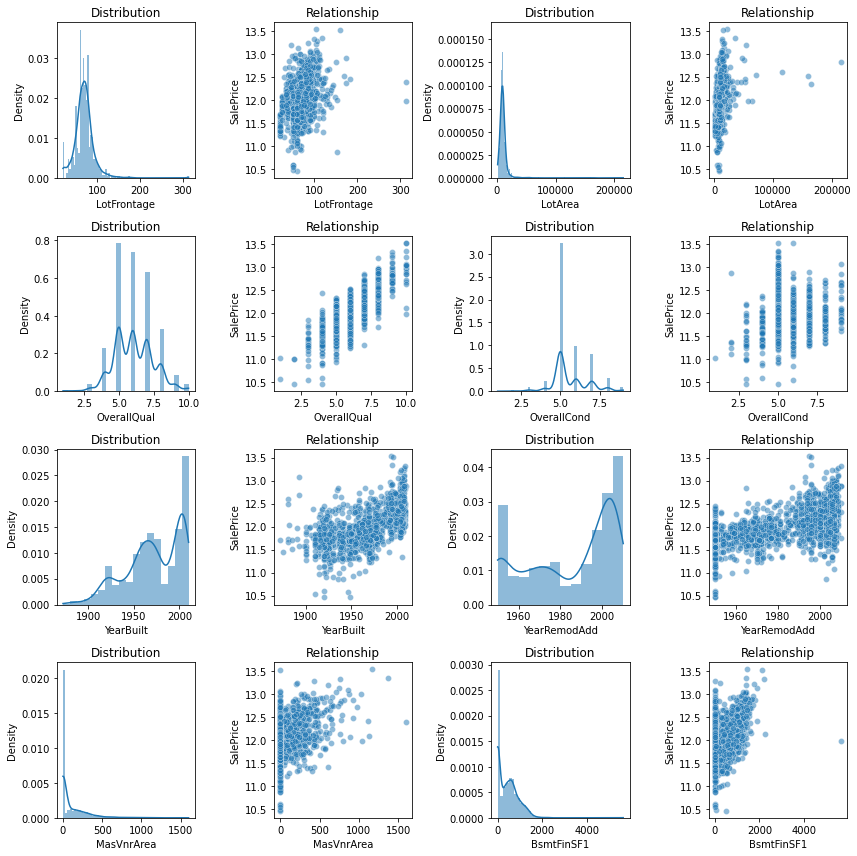

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Figure size 432x288 with 0 Axes>

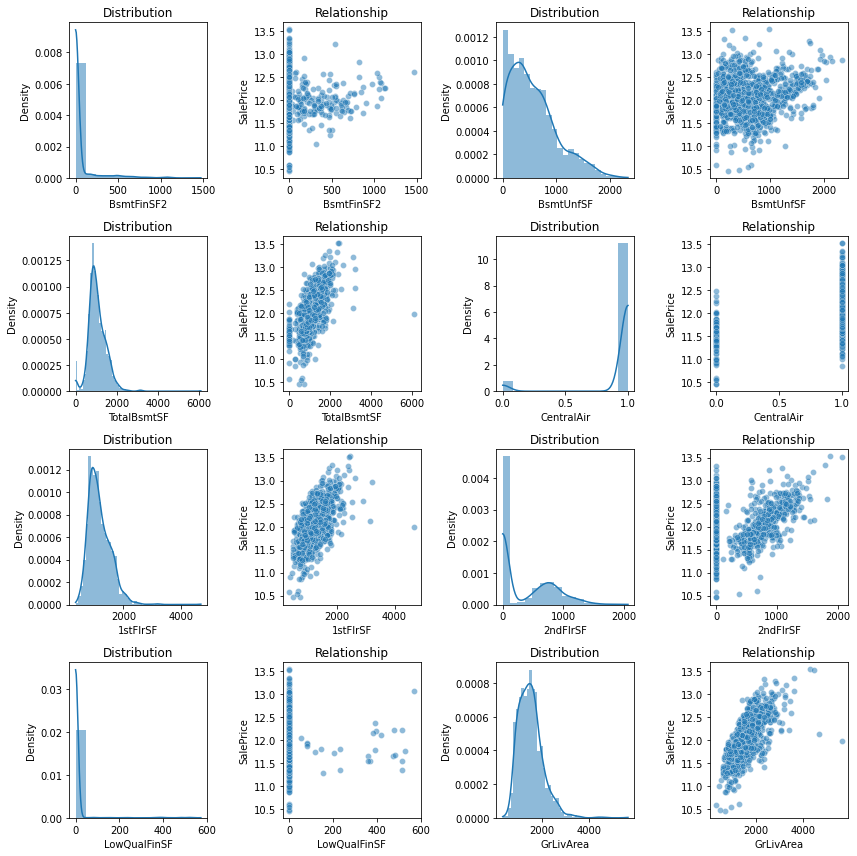

<Figure size 432x288 with 0 Axes>

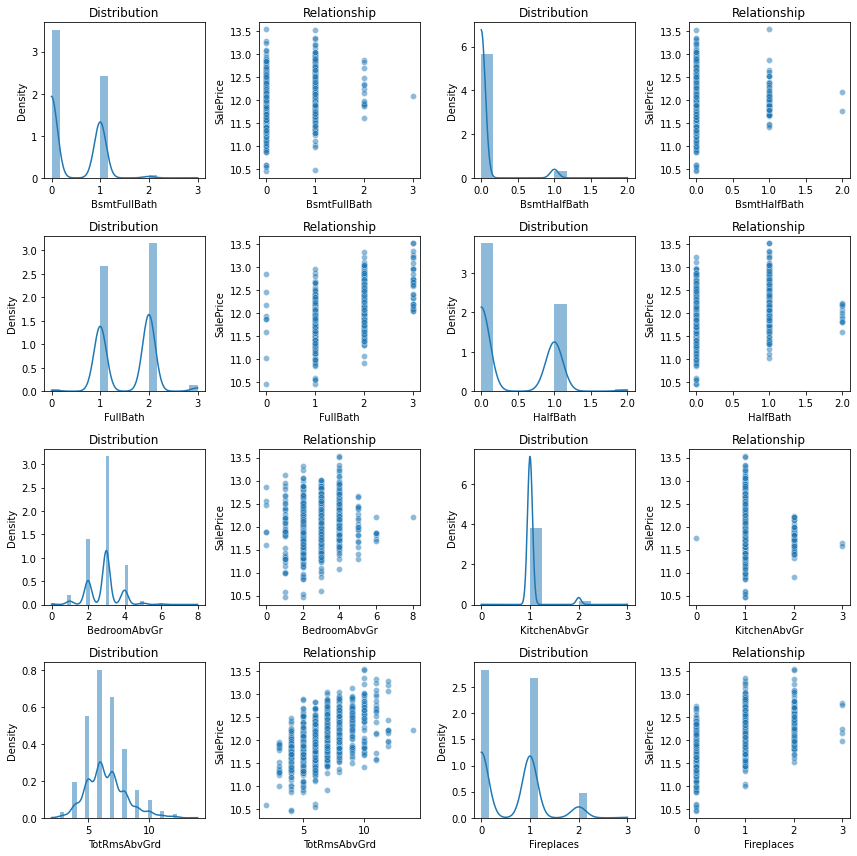

<Figure size 432x288 with 0 Axes>

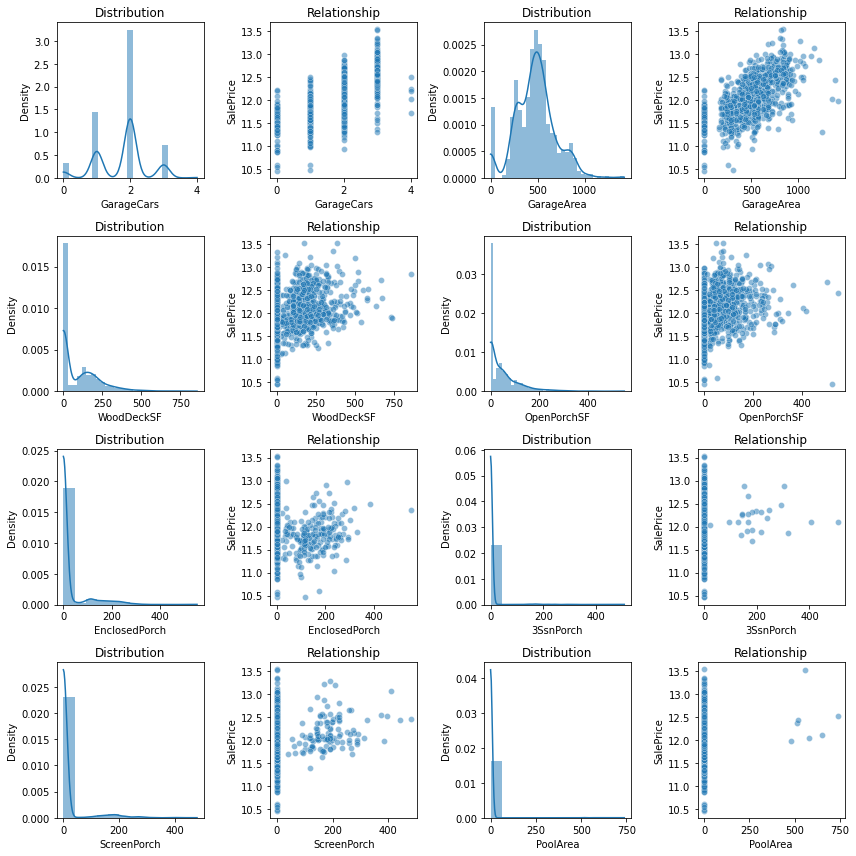

<Figure size 432x288 with 0 Axes>

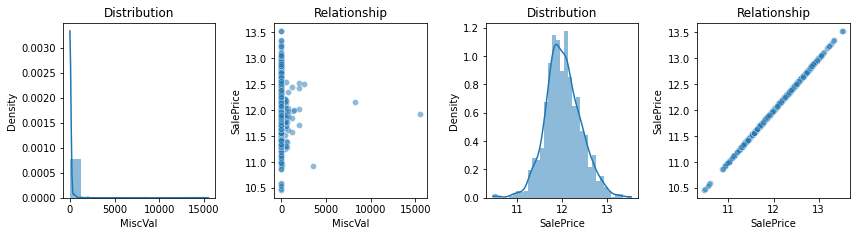

<Figure size 432x288 with 0 Axes>

In [107]:
# We want to split the numerical and categorical features into groups to view the data better
# To do this, we'll group these in sets of 10

# How many groups are needed?
#  Each will be a 4x4 grid. Total of 16 charts per plot
#  Each plot will have two charts, total of 8 features per plot
numerical_groups   = math.ceil(len(numerical_features.values)/8)
categorical_groups = math.ceil(len(categorical_features.values)/8)

total_groups       = numerical_groups + categorical_groups

numerical_step     = 8
categorical_step   = 8

group_num = np.empty(int(numerical_groups), dtype = pd.Series)
for grp in np.arange(numerical_groups):
#  print(grp * numerical_step)
  st = int(grp * numerical_step)
  en = int((grp+1) * numerical_step - 1)+1
  group_num[int(grp)] = numerical_features[st:en]


group_cat = np.empty(int(categorical_groups), dtype = pd.Series)
for grp in np.arange(categorical_groups):
  #print(grp * numerical_step)
  st = int(grp * categorical_step)
  en = int((grp+1) * categorical_step - 1)+1
  group_cat[int(grp)] = categorical_features[st:en]


# EDA of all groups
print(color.BOLD + color.UNDERLINE + "Visualisation of distribution and relationship of numerical features vs SalePrice" + color.END)
groups = group_num
for grp in groups:
    plt.figure(figsize=(12, 12))
    i = 1
    for feature in grp:
        # Distribution Plot
        width  = 4
        height = 4
        _=plt.subplot(height, width, i)
        _=sns.histplot(train_df_filled[feature], kde=True, stat="density", linewidth=0)
        _=plt.title("Distribution")
        i += 1

        # Scatter Plot
        _=plt.subplot(height, width, i)
        _=sns.scatterplot(data=train_df_filled, x=feature, y="SalePrice", alpha=0.5)
        _=plt.title("Relationship")
        i += 1
    plt.tight_layout()
    plt.show()
    plt.clf()


##### 2.3 Visualisation of the data
###### 2.3.2.1 Numerical Outliers
* **LotFrontage** > 250
* **LotArea** > 100000
* **BsmtFinSF1** > 4000
* **BsmtFinSF2** > 1200
* **TotalBsmtSF** > 5000
* **GrLivArea** > 4000
* **KitchenAbcGr** = 0
* **WoodDeckSF** > 750
* **OpenPorchSF** > 500
* **EnclosedPorch** > 500
* **MiscVal** > 5000

###### 2.3.2.2 Numerical Feature Engineering
* **LowQualFin**   | if LowQualFinSF == 0 then False, =>1 then True
* **BsmtFullBath** | 0 then False, =>1 then True
* **BsmtHalfBath** | 0 then False, =>1 then True
* **HalfBath**     | 0 then False, =>1 then True
* **BedroomAbvGr** | >= 5 then 5
* **KitchenAbvGr** | >=2 then 2
* **Fireplaces**   | >= 2 then 2
* **GarageCars**   | >= 3 then 3
* **HasPool**      | if PoolArea == 0 then False, >0 then True

Let's remove these outliers as not to skew our data / predictions.

In [108]:
train_df_cleaned = train_df_filled.drop(train_df_filled[(train_df.LotFrontage>200)|
                                          (train_df.LotArea>100000)|
                                          (train_df.LotFrontage > 250)|
                                          (train_df.LotArea > 100000)|
                                          (train_df.BsmtFinSF1 > 4000)|
                                          (train_df.BsmtFinSF2 > 1200)|
                                          (train_df.TotalBsmtSF > 5000)|
                                          (train_df.GrLivArea > 4000)|
                                          (train_df.KitchenAbvGr == 0)|
                                          (train_df.WoodDeckSF > 750)|
                                          (train_df.OpenPorchSF > 500)|
                                          (train_df.EnclosedPorch > 500)|
                                          (train_df.MiscVal > 5000)].index)

print(color.BOLD + color.RED + color.UNDERLINE + f'Reduction in training data from removing outliers is {np.round(100*(len(train_df)-len(train_df_cleaned))/len(train_df), 2)}%' + color.END)

Reduction in training data from removing outliers is 1.23%


In [109]:
# Feature Engineering: Numerical Features
train_df_cleaned2 = train_df_cleaned.copy()
test_df_cleaned2 = test_df_filled.copy()

for df in [train_df_cleaned2, test_df_cleaned2]:
    # Update existing features
    df['BsmtFullBath'] = df['BsmtFullBath'].apply(lambda x: False if x==0 else True)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].apply(lambda x: False if x==0 else True)
    df['HalfBath'] = df['HalfBath'].apply(lambda x: False if x==0 else True)
    df['BedroomAbvGr'] = df['BedroomAbvGr'].apply(lambda x: x if x<5 else 5)
    df['KitchenAbvGr'] = df['KitchenAbvGr'].apply(lambda x: x if x<2 else 2)
    df['Fireplaces'] = df['Fireplaces'].apply(lambda x: x if x<2 else 2)
    df['GarageCars'] = df['GarageCars'].apply(lambda x: x if x<3 else 3)
    
    # Create New Features
    df['Has_LowQualFinSF'] = df['LowQualFinSF'].apply(lambda x: False if x==0 else True)
    df['Has_Pool'] = df['PoolArea'].apply(lambda x: False if x==0 else True)

    # Drop replaced features
    df.drop(columns = ["LowQualFinSF", "PoolArea"], inplace = True)

train_df_cleaned2.shape

(1442, 80)

##### 2.3 Visualisation of the data
###### 2.3.2.3 Categorical dimension reduction

Visualisation of distribution and relationship of categorical features vs SalePrice


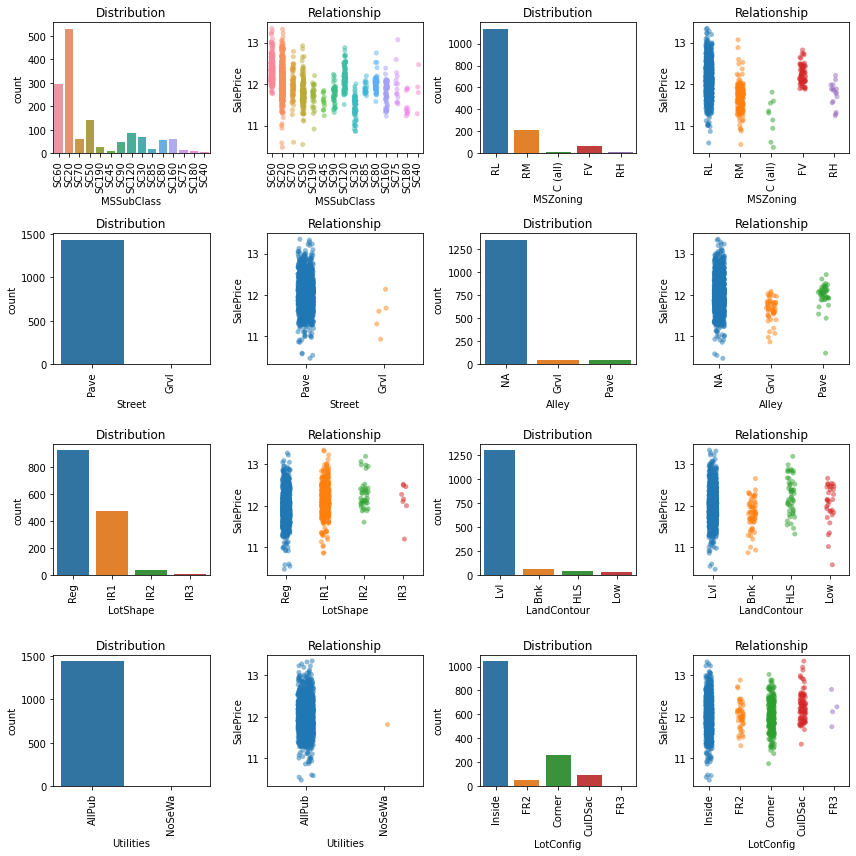

<Figure size 432x288 with 0 Axes>

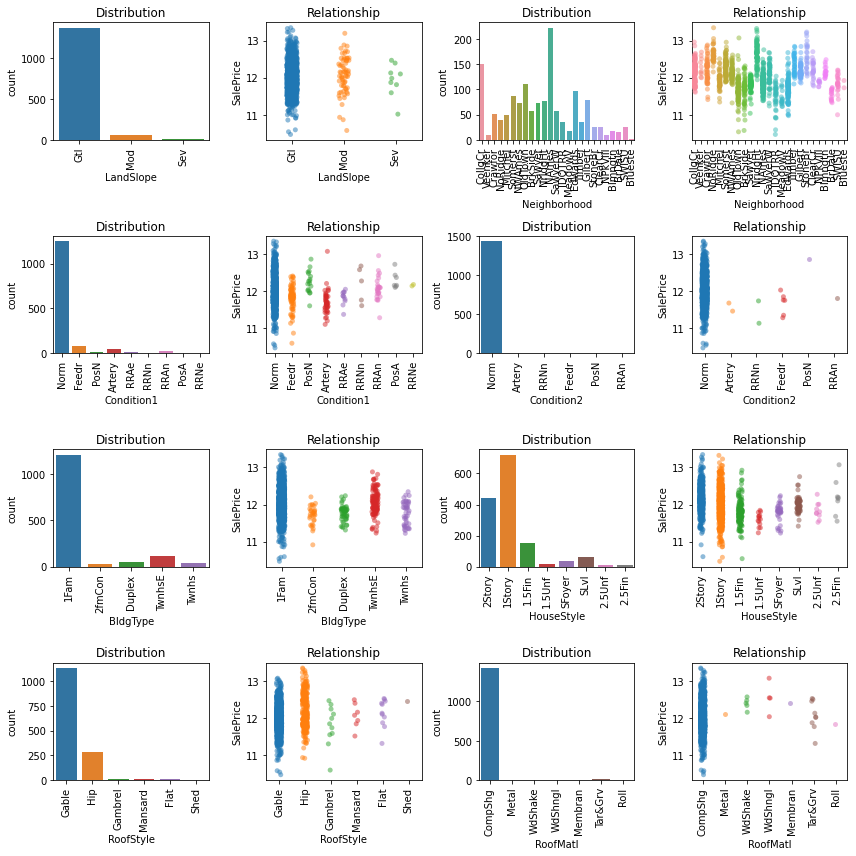

<Figure size 432x288 with 0 Axes>

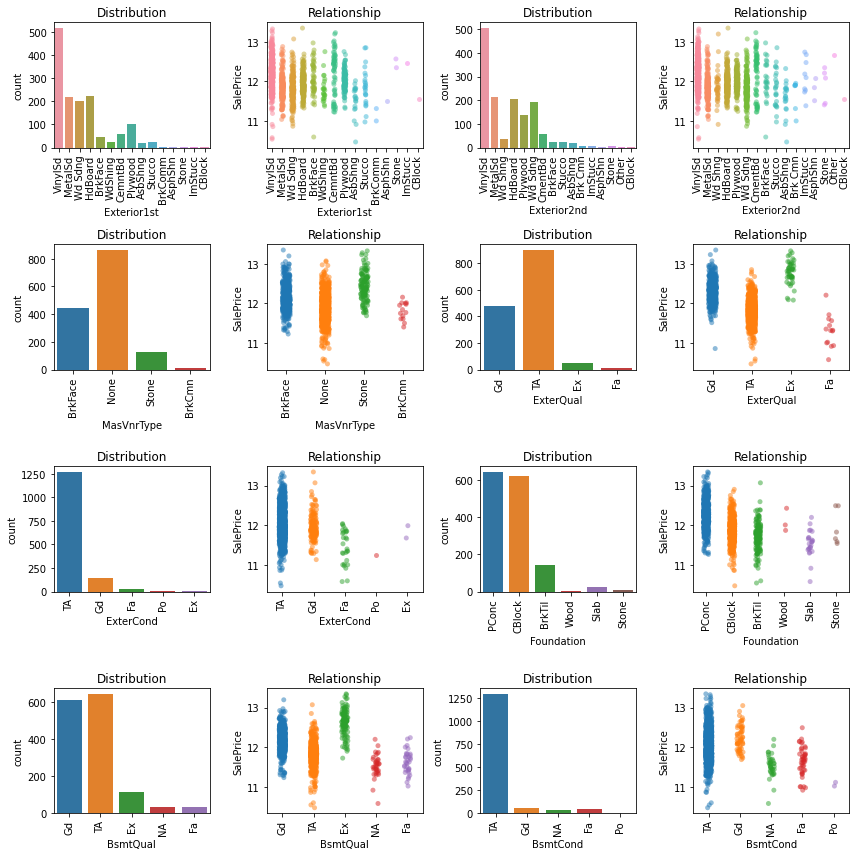

<Figure size 432x288 with 0 Axes>

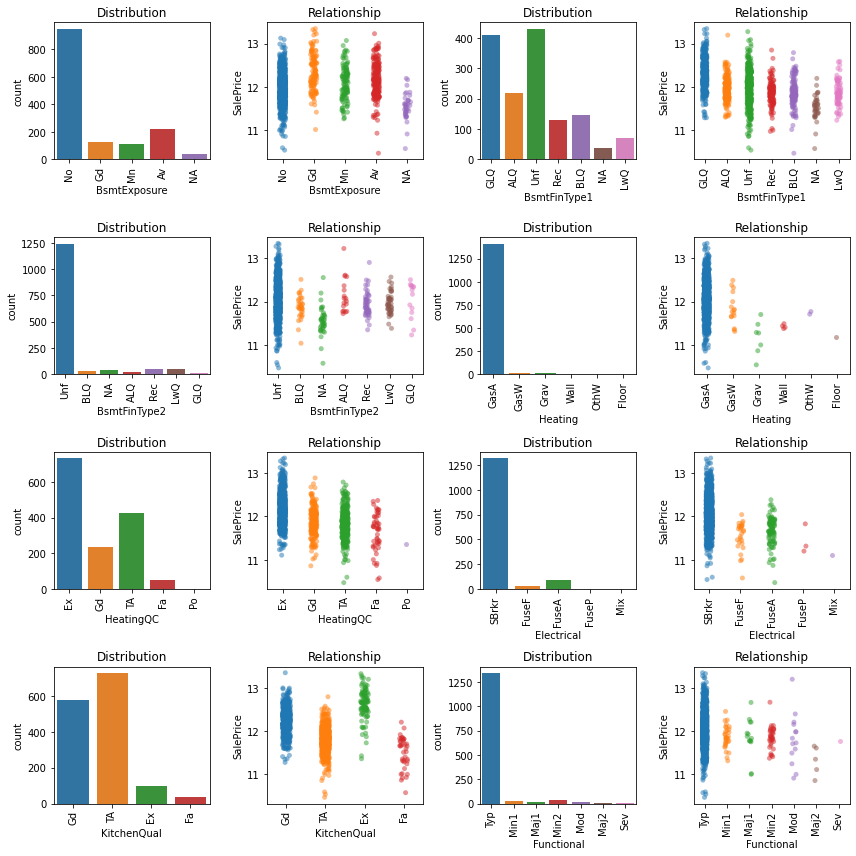

<Figure size 432x288 with 0 Axes>

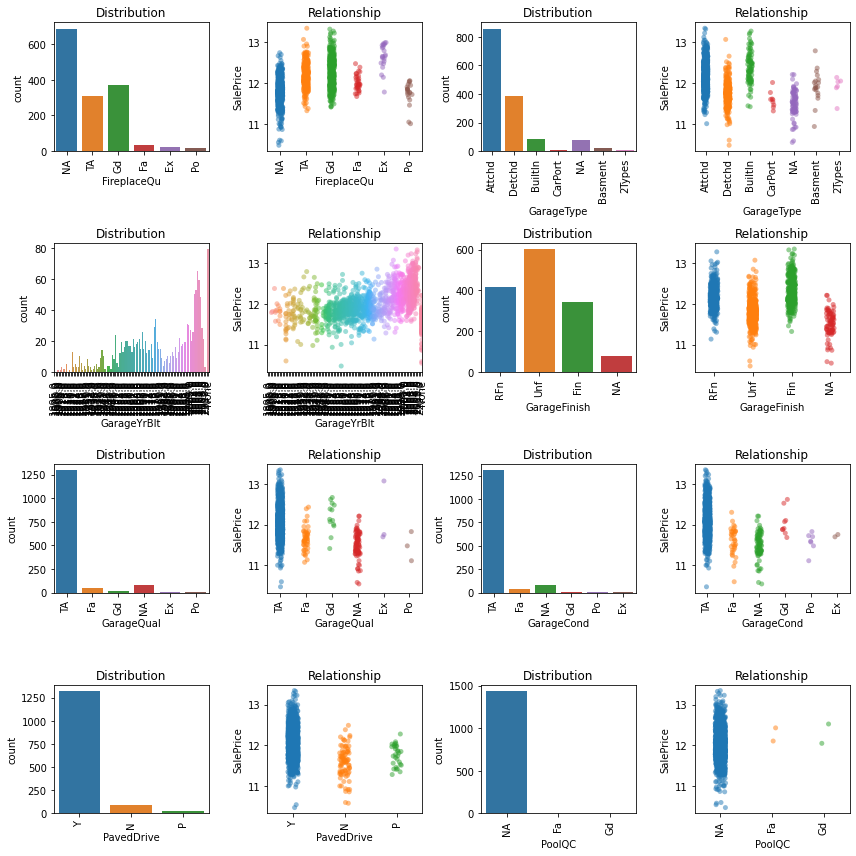

<Figure size 432x288 with 0 Axes>

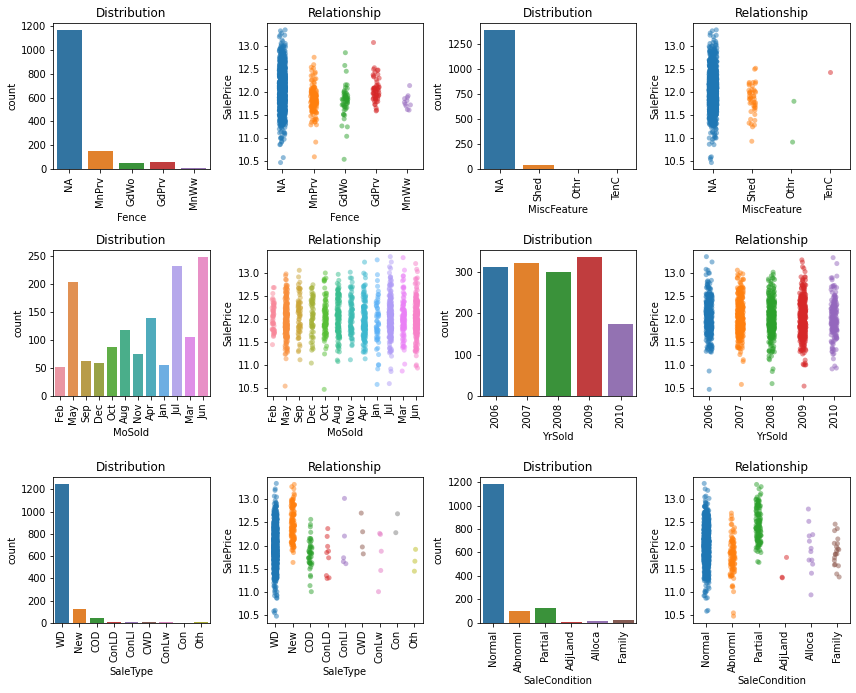

<Figure size 432x288 with 0 Axes>

In [110]:
# EDA of categorical groups
print(color.BOLD + color.UNDERLINE + "Visualisation of distribution and relationship of categorical features vs SalePrice" + color.END)
groups = group_cat
for grp in groups:
    plt.figure(figsize=(12, 12))
    i = 1
    for feature in grp:
        # Distribution Plot
        width  = 4
        height = 4
        _=plt.subplot(height, width, i)
        _=sns.countplot(x = train_df_cleaned2[feature])
        _=plt.xticks(rotation=90)
        _=plt.title("Distribution")
        i += 1

        # Scatter Plot
        _=plt.subplot(height, width, i)
        _=sns.stripplot(data=train_df_cleaned2, x=feature, y="SalePrice", alpha=0.5)
        _=plt.xticks(rotation=90)
        _=plt.title("Relationship")
        i += 1
    plt.tight_layout()
    plt.show()
    plt.clf()

##### 2.3 Visualisation of the data
###### 2.3.2.4 Categorical Feature Engineering

* **Drop** Street, Utilities, Condition2
* **RoofMatl** = ClyTile or Other
* **ExterQual** = Gd/Ex = Good, TA/FA = Average
* **Heating** = GasA or Other
* **Electrical** = SBrkr or Other
* **KitchenQual** = Gd/Ex = Good, TA/FA = Average
* **Functional** = Typ, Other
* **SaleType** = WD, New, Other

Let's make these amendments.

In [111]:
# Feature Engineering: Numerical Features
train_df_cleaned3 = train_df_cleaned2.copy()
test_df_cleaned3 = test_df_cleaned2.copy()

for df in [train_df_cleaned3, test_df_cleaned3]:
    # Update existing features
    df["RoofMatl"] = df["RoofMatl"].apply(lambda x: x if x=="CompShg" else "Other")
    df["ExterQual"] = df["ExterQual"].apply(lambda x: "Good" if x in ["Gd", "Ex"] else "Average")
    df["Heating"] = df["Heating"].apply(lambda x: x if x=="GasA" else "Other")
    df["Electrical"] = df["Electrical"].apply(lambda x: x if x=="SBrkr" else "Other")
    df["KitchenQual"] = df["KitchenQual"].apply(lambda x: "Good" if x in ["Gd", "Ex"] else "Average")
    df["Functional"] = df["Functional"].apply(lambda x: x if x=="Typ" else "Other")
    df["SaleType"] = df["SaleType"].apply(lambda x: x if x in ["WD", "New"] else "Other")

    # Drop replaced features
    df.drop(columns = ["Street", "Utilities", "Condition2"], inplace = True)

train_df_cleaned3[["RoofMatl", "ExterQual", "Heating", "Electrical", "KitchenQual", "Functional", "SaleType"]].head()

,RoofMatl,ExterQual,Heating,Electrical,KitchenQual,Functional,SaleType
Id,,,,,,,
1,CompShg,Good,GasA,SBrkr,Good,Typ,WD
2,CompShg,Average,GasA,SBrkr,Average,Typ,WD
3,CompShg,Good,GasA,SBrkr,Good,Typ,WD
4,CompShg,Average,GasA,SBrkr,Good,Typ,WD
5,CompShg,Good,GasA,SBrkr,Good,Typ,WD


Finally, lets have a look at a correlation of features to see if there are any strong correlations that we can remove?

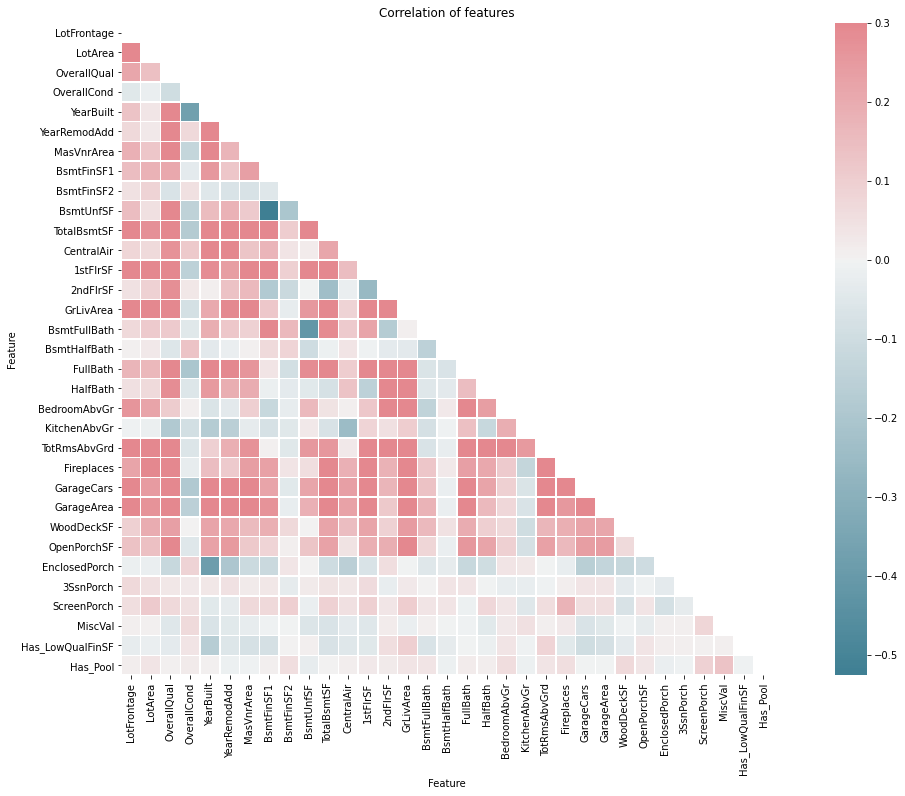

<Figure size 432x288 with 0 Axes>

In [112]:
# Are there any features that are highly correlated to each other now that we've encoded categorical
#    data to numeric? If so, can we drop them?
corr = train_df_cleaned3.drop(columns=["SalePrice"]).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(22, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, annot = False).set(title="Correlation of features")
_ = plt.xlabel("Feature")
_ = plt.ylabel("Feature")
_ = plt.show()
_ = plt.clf()

There is certainly some correlation, but no more than +- 0.5, which isn't enough for me to remove features.

### 3. Pre-Processing
###### 3.1 Categorical encoding

We'll now encode the categorical data to numbers, which is needed for the prediction models to work.


In [113]:
# Let's encode the categorical features
test_df_pre          = test_df_cleaned3.copy()
train_df_pre         = train_df_cleaned3.copy()
_train_df            = train_df_cleaned3.drop(columns = "SalePrice")

categorical_features = pd.concat([_train_df, test_df_pre]).select_dtypes(exclude = [np.number, bool]).columns
combined_df_cat      = pd.concat([_train_df, test_df_pre])[categorical_features].reset_index(drop=True)

encoder_mapping      = pd.DataFrame(index = categorical_features, columns = {"encoder", "mapping"})

for i in np.arange(len(categorical_features)):
    le = LabelEncoder()
    encoder_mapping.iloc[i]["encoder"] = le.fit(list(combined_df_cat.iloc[:,i]))
    encoder_mapping.iloc[i]["mapping"] = dict(zip(le.classes_, range(len(le.classes_))))


for feature in encoder_mapping.index:
    train_df_pre.replace({feature: encoder_mapping.loc[feature]["mapping"]}, inplace=True)
    test_df_pre.replace({feature: encoder_mapping.loc[feature]["mapping"]}, inplace=True)

### 4. Machine Learning - Prediction
##### 4.1 Configuation

We're now ready to build a prediction model.  First, we'll need to set up our configuation, where we'll set our seed and test size.

We'll also get training data ready:
* X = Independant columns (features)
* Y = Target Variable (SalePrice)

We'll then need to scale the data before proceeding.  This is completed after the train test split, as we don't want any leakage of training data into the test data.

In [114]:
SEED      = 42
test_size = 0.3   #  30% test, 70% train
cv        = 5     #  5 fold cross vailidation

X = train_df_pre.drop(["SalePrice"], axis = "columns")    # Independant columns (all the features used for prediction)
y = train_df_pre["SalePrice"]                             # Target Variable

##### 4.2 Train Test Split
We now need to split the training data into a further train test split, using the configuation above.

In [115]:
# Create training and test sets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=SEED)

###### 3.2 Scaling the data

Now that each feature is encoded to a number, we should scale the data.

In [116]:
# Set up the scaler
scaler                    = StandardScaler()

# Fit and Transforn the scaling to both the train and test dataset
X_train_scaled            = pd.DataFrame(scaler.fit_transform(X_train_unscaled))
X_test_scaled             = pd.DataFrame(scaler.transform(X_test_unscaled))
test_df_scaled            = pd.DataFrame(scaler.transform(test_df_pre))


# Amend the columns of the scaled data to match those of the original data frame
X_train_scaled.columns    = X_train_unscaled.columns.values
X_test_scaled.columns     = X_test_unscaled.columns.values
test_df_scaled.columns    = test_df_pre.columns.values


# Amend the index of the scaled data to match those of the original data frame
X_train_scaled.index      = X_train_unscaled.index.values
X_test_scaled.index       = X_test_unscaled.index.values
test_df_scaled.index      = test_df_pre.index.values


# Output the final data frames. 
X_train                   = X_train_scaled
X_test                    = X_test_scaled
test_df_processed         = test_df_scaled

train_df_processed        = pd.concat([pd.concat([X_train, y_train], axis = 1), pd.concat([X_test, y_test], axis = 1)]).sort_index()


print(color.BOLD + color.UNDERLINE + "Head of the scaled, encoded and clened training data frame" + color.END)
print(X_train.head(n=3))
print()
print(color.BOLD + color.UNDERLINE + "Head of the scaled, encoded and clened test data frame" + color.END)
print(test_df_processed.head(n=3))

Head of the scaled, encoded and clened training data frame
      MSSubClass  MSZoning  LotFrontage   LotArea     Alley  LotShape  \
1208   -0.583005 -0.043361     0.012510 -0.163767  0.036301   0.74264   
1112    0.802422 -0.043361     0.511418  0.101754  0.036301   0.74264   
1394   -0.860091  1.577043    -0.486398  0.164927  4.106041   0.74264   

      LandContour  LotConfig  LandSlope  Neighborhood  ...    PoolQC  \
1208     0.309123   0.576599  -0.219894     -1.228821  ...  0.051477   
1112     0.309123   0.576599  -0.219894      0.273862  ...  0.051477   
1394     0.309123   0.576599  -0.219894      0.774756  ...  0.051477   

         Fence  MiscFeature   MiscVal    MoSold    YrSold  SaleType  \
1208  0.463555    -0.179538 -0.132091  0.811592 -1.375494  0.364574   
1112  0.463555    -0.179538 -0.132091  1.767502  0.123289  0.364574   
1394  0.463555    -0.179538 -0.132091 -1.737502  0.123289  0.364574   

      SaleCondition  Has_LowQualFinSF  Has_Pool  
1208       0.220791     

##### 4.3 First Model
###### Linear and Ensemble Mix

To start, we'll try several Linear and Ensemble models.
* Ridge Regression
* Lasso
* Random Forest Regression
* Ada
* Extra Trees Regression
* Gradiant Boosting Regression

For the Ensemble's, I'll use an n_estimator of 20.
We'll use negative mean squred log error as the scoring mechanism and apply a cross validation 5.

In [117]:
# Ridge Regression (L2 Regularization)
alphas = np.arange(1, 10, 1)
ridge = RidgeCV(alphas, normalize=True)
ridge.fit(X_train, y_train)
best_alpha = ridge.alpha_

iterations = 5
for i in range(iterations):
    alphas = [best_alpha*x for x in np.arange(0.1, 2, 0.1)]
    ridge = RidgeCV(alphas, normalize=True)
    ridge.fit(X_train, y_train)
    best_alpha = ridge.alpha_

ridge_score = np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))

In [118]:
# Lasso Regression (L1 Regularization)
lasso = LassoCV(alphas=None, max_iter=100000, normalize=True)
lasso.fit(X_train, y_train)
best_alpha = lasso.alpha_
lasso_score = np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))

In [119]:
forest = RandomForestRegressor(n_estimators = 20, random_state = SEED)
forest.fit(X_train, y_train)

ada = AdaBoostRegressor(n_estimators = 20, random_state = SEED)
ada.fit(X_train, y_train)

bagging = BaggingRegressor(n_estimators = 20, random_state = SEED)
bagging.fit(X_train, y_train)

ETR = ExtraTreesRegressor(n_estimators = 20, random_state = SEED)
ETR.fit(X_train, y_train)

GBR = GradientBoostingRegressor(n_estimators = 20, random_state = SEED)
GBR.fit(X_train, y_train)

forest_score = np.sqrt(-cross_val_score(forest, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))
ada_score = np.sqrt(-cross_val_score(ada, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))
bagging_score = np.sqrt(-cross_val_score(bagging, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))
ETR_score = np.sqrt(-cross_val_score(ETR, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))
GBR_score = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=cv, scoring='neg_mean_squared_log_error'))

In [120]:
results = pd.DataFrame({"Ridge":[round(np.mean(ridge_score),4)],
                        "Lasso":[round(np.mean(lasso_score),4)],
                        "Forest":[round(np.mean(forest_score),4)],
                        "Ada":[round(np.mean(ada_score),4)],
                        "Bagging":[round(np.mean(bagging_score),4)],
                        "ETR":[round(np.mean(ETR_score),4)], 
                        "GBR":[round(np.mean(GBR_score),4)]},  
                       index = ["RMSLE"])
results

,Ridge,Lasso,Forest,Ada,Bagging,ETR,GBR
RMSLE,0.0092,0.0092,0.0111,0.0128,0.0111,0.0113,0.0128


Our best score is from a **Lasso Regression**, which gives us an RMSE of 0.0092.
The best ensemble method is **Bagging**, closely followed by **Random Forest**.

I'll take these three models forward and see if we can improve them using hyper parameters.

##### 4.4 Hyper Parameter Tuning
###### Tuning Lasso Regression

In [121]:
lasso_param_grid = {
    "n_alphas": [50, 100, 200, 500, 1000],
    "max_iter": [500, 1000, 2000, 5000],
    "selection": ["cyclic", "random"],
    "random_state": [SEED]
}
print(color.UNDERLINE + "Lasso Hyper Parameter Grid" + color.END)
lasso_param_grid

Lasso Hyper Parameter Grid


{'n_alphas': [50, 100, 200, 500, 1000],
 'max_iter': [500, 1000, 2000, 5000],
 'selection': ['cyclic', 'random'],
 'random_state': [42]}

In [122]:
grid_search_lasso = GridSearchCV(estimator = lasso,
                                param_grid = lasso_param_grid,
                                cv = cv,
                                n_jobs = -1,
                                verbose = 2)
_ = grid_search_lasso.fit(X_train, y_train)

print(color.BOLD + color.UNDERLINE + "Best parameters are:" + color.END)
print(color.BOLD + f"{grid_search_lasso.best_params_}" + color.END)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters are:
{'max_iter': 500, 'n_alphas': 500, 'random_state': 42, 'selection': 'random'}


In [123]:
lasso_best_grid = grid_search_lasso.best_estimator_
lasso_score_2 = np.sqrt(-cross_val_score(lasso_best_grid, X_train, y_train, scoring = "neg_mean_squared_log_error", cv = cv))

In [124]:
bagging_param_grid = {
    "bootstrap":[True, False],
    "max_features":[1, 4, 10],
    "max_samples":[1, 4],
    "n_estimators":[10, 75, 250],
    "random_state": [SEED]
}

print(color.UNDERLINE + "Bagging Regressor Hyper Parameter Grid" + color.END)
bagging_param_grid

Bagging Regressor Hyper Parameter Grid


{'bootstrap': [True, False],
 'max_features': [1, 4, 10],
 'max_samples': [1, 4],
 'n_estimators': [10, 75, 250],
 'random_state': [42]}

In [125]:
grid_search_bagging = GridSearchCV(estimator = bagging,
                                param_grid = bagging_param_grid,
                                cv = cv,
                                n_jobs = -1,
                                verbose = 2)
_ = grid_search_bagging.fit(X_train, y_train)

print(color.BOLD + color.UNDERLINE + "Best parameters are:" + color.END)
print(color.BOLD + f"{grid_search_bagging.best_params_}" + color.END)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters are:
{'bootstrap': False, 'max_features': 10, 'max_samples': 4, 'n_estimators': 250, 'random_state': 42}


In [126]:
bagging_best_grid = grid_search_bagging.best_estimator_
bagging_score_2 = np.sqrt(-cross_val_score(bagging_best_grid, X_train, y_train, scoring = "neg_mean_squared_log_error", cv = cv))

In [146]:
forest_param_grid = {
    "bootstrap":[True, False],
    "max_depth":[80, 100, None],
    "max_features":[4, 10, "auto"],
    "min_samples_leaf":[1, 4],
    "min_samples_split":[2, 6, 10],
    "n_estimators":[75, 250],
    "random_state":[SEED]
}

print(color.UNDERLINE + "Random Forest Regressor Hyper Parameter Grid" + color.END)
forest_param_grid

Random Forest Regressor Hyper Parameter Grid


{'bootstrap': [True, False],
 'max_depth': [80, 100, None],
 'max_features': [4, 10, 'auto'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 6, 10],
 'n_estimators': [75, 250],
 'random_state': [42]}

In [147]:
grid_search_forest = GridSearchCV(estimator = forest,
                                param_grid = forest_param_grid,
                                cv = cv,
                                n_jobs = -1,
                                verbose = 2)
_ = grid_search_forest.fit(X_train, y_train)

print(color.BOLD + color.UNDERLINE + "Best parameters are:" + color.END)
print(color.BOLD + f"{grid_search_forest.best_params_}" + color.END)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters are:
{'bootstrap': False, 'max_depth': 80, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250, 'random_state': 42}


In [129]:
forest_best_grid = grid_search_forest.best_estimator_
forest_score_2 = np.sqrt(-cross_val_score(forest_best_grid, X_train, y_train, scoring = "neg_mean_squared_log_error", cv = cv))

##### 4.5 Results of the Hyper Parameter Tuning

In [130]:
results = pd.DataFrame({"Lasso":[round(np.mean(lasso_score),7), round(np.mean(lasso_score_2),7)],
                        "Forest":[round(np.mean(forest_score),7), round(np.mean(forest_score_2),7)],
                        "Bagging":[round(np.mean(bagging_score),7), round(np.mean(bagging_score_2),7)]},  
                       index = ["Before", "After"])
print(color.BOLD + color.UNDERLINE + "RMSLE score" + color.END)
results

RMSLE score


,Lasso,Forest,Bagging
Before,0.009159,0.011107,0.011104
After,0.009151,0.010445,0.023263


Great! The Lasso and Forest models have marginally improved. The bagging has got slightly worse!

How do these look across the test data?

In [131]:
y_pred_lasso_log1p       = lasso_best_grid.predict(X_test)
y_pred_bagging_log1p     = bagging_best_grid.predict(X_test)
y_pred_forest_log1p      = forest_best_grid.predict(X_test)


lasso_test_RMSLE         = np.sqrt(MSLE(y_test, y_pred_lasso_log1p))
bagging_test_RMSLE       = np.sqrt(MSLE(y_test, y_pred_bagging_log1p))
forest_test_RMSLE        = np.sqrt(MSLE(y_test, y_pred_forest_log1p))

y_pred_lasso             = np.expm1(y_pred_lasso_log1p)
y_pred_bagging           = np.expm1(y_pred_bagging_log1p)
y_pred_forest            = np.expm1(y_pred_forest_log1p)
y_test_expm1             = np.expm1(y_test)

lasso_test_RMSLE_expm1   = np.sqrt(MSLE(y_test_expm1, y_pred_lasso))
bagging_test_RMSLE_expm1 = np.sqrt(MSLE(y_test_expm1, y_pred_bagging))
forest_test_RMSLE_expm1  = np.sqrt(MSLE(y_test_expm1, y_pred_forest))

results = pd.DataFrame({"Lasso":[round(np.mean(lasso_score),7), round(np.mean(lasso_score_2),7), lasso_test_RMSLE, lasso_test_RMSLE_expm1],
                        "Forest":[round(np.mean(forest_score),7), round(np.mean(forest_score_2),7), forest_test_RMSLE, forest_test_RMSLE_expm1],
                        "Bagging":[round(np.mean(bagging_score),7), round(np.mean(bagging_score_2),7), bagging_test_RMSLE, bagging_test_RMSLE_expm1]},  
                       index = ["No Tuning", "Hyper Tuning", "Test Data", "Test Data (expm1)"])
print(color.BOLD + color.UNDERLINE + "RMSLE score" + color.END)
results

RMSLE score


,Lasso,Forest,Bagging
No Tuning,0.009159,0.011107,0.011104
Hyper Tuning,0.009151,0.010445,0.023263
Test Data,0.009512,0.010191,0.023818
Test Data (expm1),0.121629,0.130587,0.309507


Pretty good.  The test data has performed similar to the hyper tuned training data.
We applied a log1p transformation to the SalePrice, due to skewness.  When we revere this (expm1), the score is slightly worse but still good, except for Bagging.

We'll proceeed with Lasso and Forest only.

How does this look when visualised?

##### 4.6 Visualisation of results

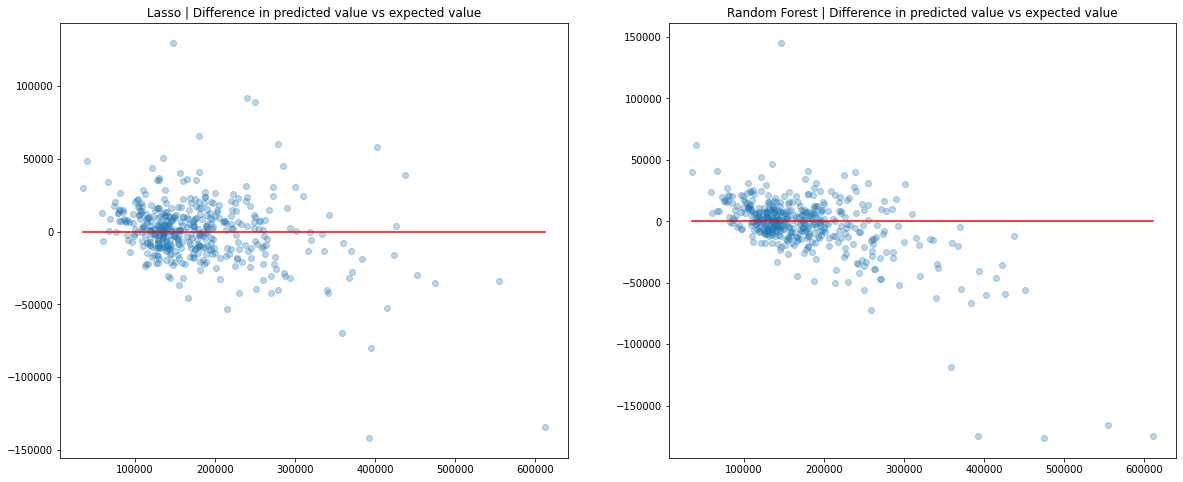

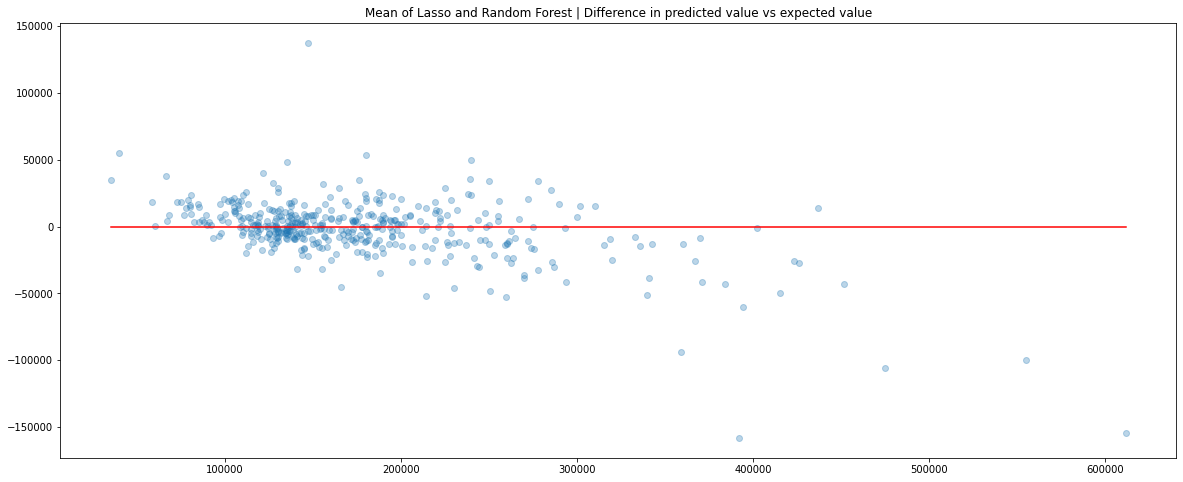

RMSLE of the mean of the lasso and random forest predictions
0.1185


In [218]:
t = np.linspace(min(y_test_expm1), max(y_test_expm1), len(y_test_expm1))

# Figure
plt.figure(figsize=(20, 8))

# Distribution Plot
plt.subplot(1, 2, 1)
plt.title("Lasso | Difference in predicted value vs expected value")
plt.plot(t, np.linspace(0,0,len(t)), c = "red")
plt.scatter(y_test_expm1, y_pred_lasso - y_test_expm1, alpha = 0.3)

plt.subplot(1,2,2)
plt.title("Random Forest | Difference in predicted value vs expected value")
plt.plot(t, np.linspace(0,0,len(t)), c = "red")
plt.scatter(y_test_expm1, y_pred_forest - y_test_expm1, alpha = 0.3)

plt.show()

plt.figure(figsize=(20, 8))
plt.title("Mean of Lasso and Random Forest | Difference in predicted value vs expected value")
plt.plot(t, np.linspace(0,0,len(t)), c = "red")
plt.scatter(y_test_expm1, np.mean([y_pred_forest, y_pred_lasso],axis=0) - y_test_expm1, alpha = 0.3)
plt.show()


print(color.BOLD + color.RED + "RMSLE of the mean of the lasso and random forest predictions" + color.END)
print(
    round(np.sqrt(MSLE(y_test_expm1, np.mean([y_pred_forest, y_pred_lasso],axis=0))),4)
)

We can see that both Lasso and Random Forest are poor at predicting the more expensive properties.  This isn't surprising considering we have much less data.

However, by taking the mean of both results, we get a better result and an improved RMSLE.

**Summary**

Whilst a good result, it's clear that properties with a low sale price, or (more significantly) properties with a higher sale price are being predicted incorrectly.

Would training a model on only high-end properties make a difference?

For now, I'll submit my results and delve deeper another day.

In [227]:
final_y_pred_lasso_log1p       = lasso_best_grid.predict(test_df_scaled)
final_y_pred_forest_log1p      = forest_best_grid.predict(test_df_scaled)

final_y_pred_lasso             = np.expm1(final_y_pred_lasso_log1p)
final_y_pred_forest            = np.expm1(final_y_pred_forest_log1p)

final_y_pred = np.mean([final_y_pred_lasso, final_y_pred_forest], axis = 0)

# Submitting Prediction
submission = pd.DataFrame({'Id': test_df_scaled.index, 'SalePrice': final_y_pred})
submission.head()

,Id,SalePrice
0,1461,123590.149797
1,1462,158959.860645
2,1463,180384.176486
3,1464,187580.298497
4,1465,190310.796461


In [228]:
submission.to_csv('submission.csv', index=False)
print('Submission saved.')

Submission saved.
